Simulated 10000 terminal payoffs ST (vector in R^10000)
Sample min: 48.46, max: 232.86, mean: 108.30
Interpretation: Each ST[i] is a payoff in one 'state'—discrete approximation of continuous uncertainty for realistic distributions.


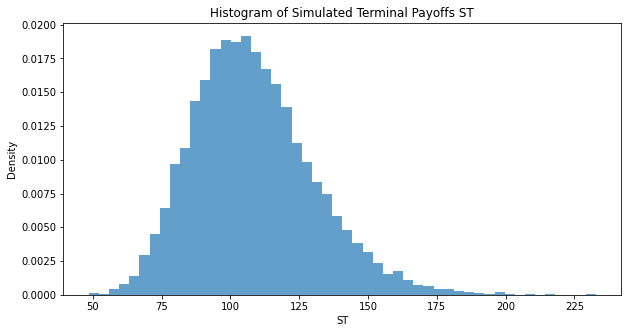

Moments (uniform P):
  Mean E[ST]: 108.30
  Variance: 482.46
  Std Dev: 21.97

Weighted mean with skewed P: 106.68 (vs uniform 108.30)
Explanation: P enters as weights—uniform for risk-neutral/MC; real/historical P for physical expectations (e.g., biased views shift mean).

Payoff matrix M: 10000 states x 5 assets
  Rank of M: 5
  Market: Incomplete (rank 5 < 10000 states)
Interpretation: Low rank (always here since assets << states) → incomplete market. Can't replicate arbitrary claims—real-world limit even in 'large' economies (e.g., thousands of paths, few assets).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Task 1: Simulate payoff sample ST as vector in R^|Ω| (large discrete space)
# Real-world tie-in: Large |Ω| approximates continuous distributions (e.g., Monte Carlo for TSLA terminal prices under lognormal—realistic for option pricing with many paths).
np.random.seed(42)  # Fixed for reproducibility
num_paths = 10000   # Large state space |Ω| = 10,000 scenarios
S0 = 100            # Initial stock price
mu = 0.08           # Drift
sigma = 0.2         # Volatility
T = 1.0             # Time horizon

# Simulate terminal payoffs ST (lognormal geometric Brownian motion approximation)
Z = np.random.standard_normal(num_paths)
ST = S0 * np.exp((mu - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

print(f"Simulated {num_paths} terminal payoffs ST (vector in R^{num_paths})")
print(f"Sample min: {ST.min():.2f}, max: {ST.max():.2f}, mean: {ST.mean():.2f}")
print("Interpretation: Each ST[i] is a payoff in one 'state'—discrete approximation of continuous uncertainty for realistic distributions.")

# Task 2: Histogram and basic moments; role of probability vector P
# Real-world: Histogram visualizes distribution (e.g., TSLA return vol); moments for risk (mean return, variance). Uniform P assumes equal likelihood; real P from historical/data for weighted expectations.
plt.figure(figsize=(10, 5))
plt.hist(ST, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Simulated Terminal Payoffs ST')
plt.xlabel('ST')
plt.ylabel('Density')
plt.show()

# Basic moments (assuming uniform P: equal weight 1/num_paths)
mean_ST = np.mean(ST)
var_ST = np.var(ST)
std_ST = np.std(ST)

print(f"Moments (uniform P):")
print(f"  Mean E[ST]: {mean_ST:.2f}")
print(f"  Variance: {var_ST:.2f}")
print(f"  Std Dev: {std_ST:.2f}")

# Role of P: Weighted expectation E[ST] = sum P_i * ST_i
# Example: Skewed P favoring low states (e.g., bearish view)
P_skewed = np.exp(-0.001 * (ST - ST.mean())**2)  # Dummy weights higher near mean for illustration
P_skewed /= P_skewed.sum()  # Normalize to probabilities

weighted_mean = np.dot(P_skewed, ST)
print(f"\nWeighted mean with skewed P: {weighted_mean:.2f} (vs uniform {mean_ST:.2f})")
print("Explanation: P enters as weights—uniform for risk-neutral/MC; real/historical P for physical expectations (e.g., biased views shift mean).")

# Task 3: Payoff matrix M rank and completeness
# Real-world: M columns = traded assets (e.g., bond + few stocks/options). Rank < |Ω| = incomplete—even with many states, limited assets can't span all risks (e.g., hedging TSLA with S&P + bond leaves idiosyncratic risk).
num_assets = 5  # Few traded (e.g., bond + 4 stocks)
M = np.random.normal(100, 20, size=(num_paths, num_assets))  # Random payoffs for illustration
M[:, 0] = 1  # First column: risk-free bond pays 1

rank_M = np.linalg.matrix_rank(M)
completeness = "Complete" if rank_M == num_paths else "Incomplete"

print(f"\nPayoff matrix M: {num_paths} states x {num_assets} assets")
print(f"  Rank of M: {rank_M}")
print(f"  Market: {completeness} (rank {rank_M} {'==' if completeness=='Complete' else '<'} {num_paths} states)")
print("Interpretation: Low rank (always here since assets << states) → incomplete market. Can't replicate arbitrary claims—real-world limit even in 'large' economies (e.g., thousands of paths, few assets).")